In [1]:
import os
from os import getcwd
import pandas as pd
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from pathlib import Path
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
train = pd.read_parquet("/Users/camilleepitalon/Documents/DSB/04_python_for_data_science/03_projects/bike_counters-main/data/train.parquet")
test = pd.read_parquet("/Users/camilleepitalon/Documents/DSB/04_python_for_data_science/03_projects/bike_counters-main/data/train.parquet")

In [3]:
train.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [4]:
test.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [5]:
print(test["date"].min())
print(test["date"].max())

2020-09-01 01:00:00
2021-08-09 23:00:00


In [6]:
def _encode_dates(X):
    X = X.copy()
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    return X.drop(columns=["date"])

In [7]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [8]:
_encode_dates(X_train[["date"]].head())

,year,month,day,weekday,hour
400125,2020,9,1,1,1
408305,2020,9,1,1,1
87516,2020,9,1,1,1
98518,2020,9,1,1,1
875137,2020,9,1,1,1


## 1. Use external data

In [9]:
df_weather = pd.read_csv("submissions/starting_kit/external_data.csv", parse_dates=["date"])
df_weather

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,7149,2020-09-30 09:00:00,101540,-30,8,230,4.4,289.95,286.85,82,...,400.0,7.0,6.0,2200.0,NaN,NaN,NaN,NaN,NaN,NaN
3318,7149,2020-09-30 12:00:00,101320,-210,8,190,4.9,292.05,285.55,66,...,870.0,7.0,6.0,1900.0,NaN,NaN,NaN,NaN,NaN,NaN
3319,7149,2020-09-30 15:00:00,101140,-180,7,190,4.1,291.55,286.45,72,...,820.0,7.0,6.0,2200.0,NaN,NaN,NaN,NaN,NaN,NaN
3320,7149,2020-09-30 18:00:00,101020,-130,6,190,2.7,290.15,285.25,73,...,2160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
X_train["orig_index"] = np.arange(X_train.shape[0])
X_train_merged = pd.merge_asof(X_train.sort_values("date"), df_weather.sort_values("date"), on='date')
X_train_merged = X_train_merged.sort_values("orig_index")
del X_train_merged["orig_index"]

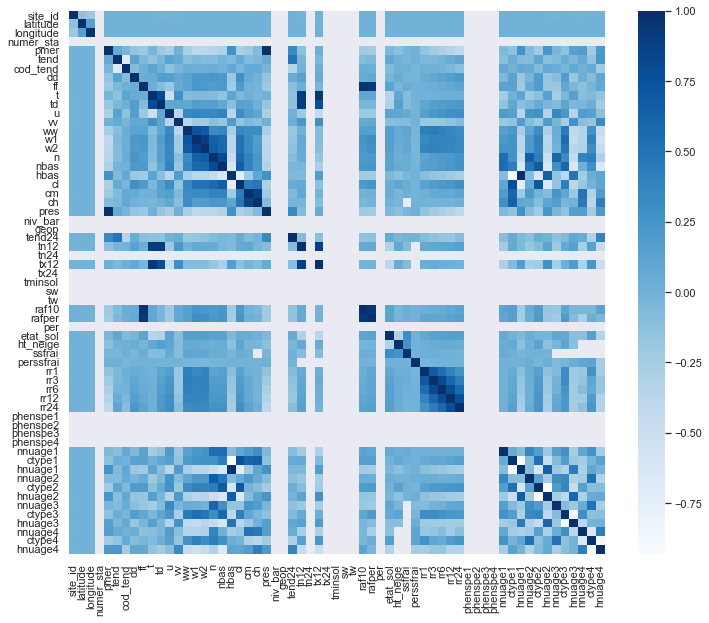

In [11]:
import seaborn as sns
corrbis = X_train_merged.corr()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(corrbis, xticklabels=corrbis.columns, yticklabels=corrbis.columns, cmap = 'Blues');

In [12]:
X_train_merged = X_train_merged.drop(["td", "longitude", "latitude", "numer_sta", "per", "site_id", "rafper", "tn24", "tx12", "raf10", "pmer", "tn12", "rr24", "niv_bar", "geop", "tx24", "phenspe1", "phenspe2", "phenspe3", "phenspe4", "tminsol", "sw", "tw", "per", "numer_sta", "rr1", "rr6", "rr12", "cm", "ch", "w1", "nbas", "w2", "hnuage1", "ssfrai", "perssfrai", "ht_neige", "tend24", "pres"], axis=1)

In [13]:
X_train_merged.columns

Index(['counter_id', 'counter_name', 'site_name', 'date',
       'counter_installation_date', 'counter_technical_id', 'tend', 'cod_tend',
       'dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', 'cl', 'etat_sol', 'rr3',
       'nnuage1', 'ctype1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3',
       'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4'],
      dtype='object')

In [14]:
def merge_external_data(X): 
    X_weather = df_weather[['date','tend', 'dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', 'cl',
       'etat_sol', 'rr3', 'nnuage1', 'ctype1', 'hnuage3']]
    X["orig_index"] = np.arange(X.shape[0])
    X_merged = pd.merge_asof(X.sort_values("date"), X_weather.sort_values("date"), on='date')
    X_merged = X_merged.sort_values("orig_index")
    X_merged['dd'] = X_merged['dd'].fillna(0)
    X_merged['ff'] = X_merged['ff'].fillna(0)
    X_merged['t'] = X_merged['t'].fillna(0)
    X_merged['u'] = X_merged['u'].fillna(0)
    X_merged['vv'] = X_merged['vv'].fillna(0)
    X_merged['ww'] = X_merged['ww'].fillna(0)
    X_merged['n'] = X_merged['n'].fillna(0)
    X_merged['hbas'] = X_merged['hbas'].fillna(0)
    X_merged['cl'] = X_merged['cl'].fillna(0)
    X_merged['etat_sol'] = X_merged['etat_sol'].fillna(0)
    X_merged['rr3'] = X_merged['rr3'].fillna(0)
    X_merged['nnuage1'] = X_merged['nnuage1'].fillna(0)
    X_merged['ctype1'] = X_merged['ctype1'].fillna(0)
    X_merged['hnuage3'] = X_merged['hnuage3'].fillna(0)
    
    del X_merged["orig_index"]
    return X_merged

In [15]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(X_train[["date"]]).head()

,year,month,day,weekday,hour
400125,2020,9,1,1,1
408305,2020,9,1,1,1
87516,2020,9,1,1,1
98518,2020,9,1,1,1
875137,2020,9,1,1,1


In [16]:
X_train_merged = merge_external_data(X_train)

In [17]:
sum(X_train_merged.isnull().values.ravel())

0

In [18]:
df = _encode_dates(X_train_merged[["date"]])
df.head()

,year,month,day,weekday,hour
0,2020,9,1,1,1
30,2020,9,1,1,1
31,2020,9,1,1,1
32,2020,9,1,1,1
33,2020,9,1,1,1


In [19]:
X_train_merged.drop(['date'], axis = 1, inplace = True)
X_train_merged = pd.concat([df, X_train_merged], axis=1)
X_train_merged.head()

,year,month,day,weekday,hour,counter_id,counter_name,site_id,site_name,counter_installation_date,...,vv,ww,n,hbas,cl,etat_sol,rr3,nnuage1,ctype1,hnuage3
0,2020,9,1,1,1,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2018-12-07,...,30000,1,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
30,2020,9,1,1,1,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2018-12-07,...,30000,1,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
31,2020,9,1,1,1,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2017-07-12,...,30000,1,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
32,2020,9,1,1,1,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2017-07-12,...,30000,1,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
33,2020,9,1,1,1,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-07-22,...,30000,1,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0


In [20]:
import matplotlib.pyplot as plt
X_train['date'].head()

400125   2020-09-01 01:00:00
408305   2020-09-01 01:00:00
87516    2020-09-01 01:00:00
98518    2020-09-01 01:00:00
875137   2020-09-01 01:00:00
Name: date, dtype: datetime64[ns]

In [21]:
y_train.shape

(455163,)

In [22]:
date = _encode_dates(train)

In [23]:
trainbis = train[['date', 'bike_count']]
trainbis = _encode_dates(trainbis)
trainbis = trainbis.drop('hour', axis=1)
trainbis = trainbis.drop('weekday', axis=1)

In [24]:
cols=["year","month","day"]
trainbis['date'] = trainbis[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
trainbis = trainbis.drop('year', axis=1)
trainbis = trainbis.drop('month', axis=1)
trainbis = trainbis.drop('day', axis=1)

In [25]:
trainbis.head()

,bike_count,date
48321,0.0,2020-9-1
48324,1.0,2020-9-1
48327,0.0,2020-9-1
48330,4.0,2020-9-1
48333,9.0,2020-9-1


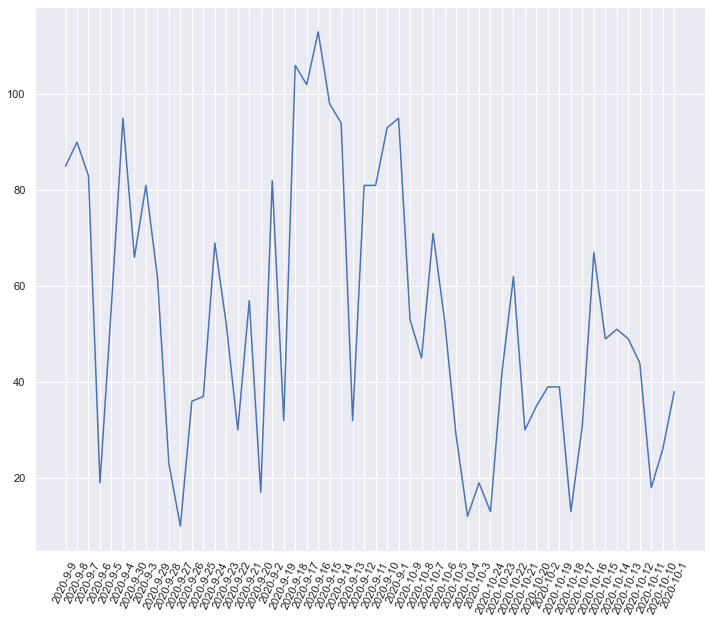

In [26]:
trainbis = trainbis.head(1000)
yy = trainbis.groupby("date").sum()
yy.sort_values(by='date', ascending=False, inplace=True)
plt.plot(yy);
plt.xticks(rotation=65)
plt.show()

## 2.  Best regressor research

#### 1. HistGradientBoostingRegressor

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler


date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]
        
numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = HistGradientBoostingRegressor(random_state=0)

pipe = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
pipe.get_params()

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipe,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

#### 2. Ridge regressor

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]


numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = Ridge()

pipe2 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.metrics import mean_squared_error

pipe2.fit(X_train, y_train)
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe2.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe2.predict(X_test), squared=False):.2f}"
)

In [ ]:
from sklearn.model_selection import GridSearchCV

pipe2.fit(X_train, y_train)
params = [{'ridge__alpha': np.linspace(-6,6,50)}]
clf = GridSearchCV(pipe2, params, cv = 5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print(clf.best_params_)

In [ ]:
pipe2.get_params()

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()
 
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]

numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = Ridge(clf.best_params_.get('ridge__alpha'), solver='sparse_cg')

pipe3 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.metrics import mean_squared_error

pipe3.fit(X_train, y_train)
print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe3.predict(X_train), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_test, pipe3.predict(X_test), squared=False):.2f}"
)

#### 3. Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]

numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = RandomForestRegressor(max_depth=2, random_state=0)

pipe4 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipe4,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

#### 4. ElastincNet

In [ ]:
from sklearn.linear_model import ElasticNet

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]

numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = ElasticNet()

pipe5 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipe5,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

In [ ]:
pipe5.fit(X_train, y_train)
bl = pipe5.predict(X_test)

In [ ]:
bl.shape

In [ ]:
y_train

#### 5. Lightgbm

In [81]:
reg = ltb.LGBMRegressor()
reg.fit(_encode_dates(X_train.drop(columns=['counter_installation_date', 'counter_name', 'site_id', 'site_name', 'counter_technical_id', 'latitude', 'longitude', 'orig_index'])), y_train)

print(reg.feature_name_)
print(reg.feature_importances_)

['counter_id', 'year', 'month', 'day', 'weekday', 'hour']
[845  46 697 342 320 750]


In [143]:
import lightgbm as ltb

# Call the merge_external_data function
merge_external = FunctionTransformer(merge_external_data, validate=False)

# Call the _encode_dates function to split the date column to several columns
date_encoder = FunctionTransformer(_encode_dates)

# Encode the final columns
date_one_encoder = OneHotEncoder(handle_unknown="ignore")
date_cols = ['year', 'month', 'day', 'weekday', 'hour']

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name"]

numeric_encoder = StandardScaler()
numeric_cols = ['t', 'rr3']

preprocessor = ColumnTransformer(
    [
        ("date", date_one_encoder, date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("numeric", numeric_encoder, numeric_cols) 
    ]
)
    
params = {
        'lambda_l1' : 4, 
        'lambda_l2' : 18, 
        #'num_leaves' : 99,  
        #'max_depth' : 11,
        #'num_iterations' : 240,
        #'min_child_samples' : 6,
        #'max_bin' : 53, 
        #'n_estimators' : 1,
        #'subsample_for_bin' :  200,
        #'subsample' : 1,
        #'subsample_freq' : 1,
        #'alpha' : 20, 
        #'reg_alpha' : 0.306, 
        #'reg_lambda' : 0.306, 
        #'min_split_gain' : 0.5,
        #'min_child_weight' : 1,
        #'learning_rate' : 0.025
        }

regressor = ltb.LGBMRegressor()#**params)

lgbm = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [144]:
from sklearn.model_selection import GridSearchCV

#lgbm.fit(X_train, y_train)

param_grid = {
    'lgbmregressor__num_leaves' : range(50, 201, 50)
}

grid = GridSearchCV(lgbm, param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [139]:
print(grid.best_params_)
print(grid.best_score_)

{'lgbmregressor__lambda_l2': 18}
-0.8619653923051956


In [107]:
print(grid.best_params_)
print(grid.best_score_)

{'lgbmregressor__n_estimators': 3}
-2.0207991809366477


In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]

numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    

regressor = ltb.LGBMRegressor(alpha = 20,num_leaves=100, n_estimators=200, lambda_l1=2, lambda_l2=2, max_depth=100)

pipe6 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor,
)

In [ ]:
scores = cross_val_score(
    pipe6,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

#### 6. XG Boost

In [61]:
import xgboost as xgb

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]

numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)


xg_reg = xgb.XGBRegressor(n_estimators = 91, colsample_bytree=0.3, max_depth=9, min_child_weight=4, max_delta_step=5)
    

pipe7 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    xg_reg,
)

In [31]:
pipe7.get_params()

{'memory': None,
 'steps': [('functiontransformer-1',
   FunctionTransformer(func=<function merge_external_data at 0x131b335e0>)),
  ('functiontransformer-2',
   FunctionTransformer(func=<function _encode_dates at 0x12adabca0>)),
  ('columntransformer',
   ColumnTransformer(transformers=[('date', 'passthrough',
                                    ['year', 'month', 'day', 'weekday', 'hour']),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'),
                                    ['site_name', 'etat_sol', 'nnuage1',
                                     'ctype1']),
                                   ('numeric', StandardScaler(),
                                    ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas',
                                     'hnuage3', 'tend', 'cl', 'rr3'])])),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=0.3, gamma=None,
          

In [69]:
from sklearn.model_selection import GridSearchCV
import numpy as np

pipe7.fit(X_train, y_train)

param_grid = {
              'xgbregressor__subsample' : np.linspace(0,1,100)
             }

clf = GridSearchCV(pipe7, param_grid, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)
print(clf.best_params_)

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-48-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

KeyboardInterrupt: 

In [32]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipe7,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

<ipython-input-16-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-16-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["orig_index"] = np.arange(X.shape[0])
<ipython-input-16-9ae07d9db533>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

RMSE: 0.913± 0.178


## 3. PROPHET

In [ ]:
from prophet import Prophet

In [ ]:
pip install prophet

In [ ]:
date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

    
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name", "etat_sol", "nnuage1", "ctype1"]

numeric_encoder = StandardScaler()
numeric_cols = ['dd', 'ff', 't', 'u', 'vv', 'ww', 'n', 'hbas', "hnuage3", "tend", "cl", "rr3"]

preprocessor = ColumnTransformer(
        [
            ("date", "passthrough", date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols) 
        ]
)
    
m = Prophet()
m.add_regressor('t')


pipe7 = make_pipeline(
    FunctionTransformer(merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor
)

In [ ]:
pipe7.fit(X_train)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipe7,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

## 4. SARIMA


###### https://www.youtube.com/watch?v=z-uSBE8Pxwg

#### 1. Adfuller test to check the stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
result = adfuller(y_train) 

In [ ]:
print('ADF statistic: %f' %result[0])
print('p_value: %f' %result[1])
print('critical values:')

for key, value in result[4].items():
    print('\t%s: %3.f')

#### 2. ACF and PCF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(y_train, ax=ax[0], lags=20)
ax[1] = plot_pacf(y_train, ax=ax[1], lags=20)

#### 3. Trend, seasonality and residuals

In [ ]:
dftrain = train[['date', 'bike_count']]
dftrain = dftrain.groupby("date").sum()

In [ ]:
dftrain.head()

In [ ]:
period = len(dftrain)/8
print(period)

In [ ]:
import statsmodels.api as sm
ts_decomp = sm.tsa.seasonal_decompose(dftrain,model="additive", period=2000)
ts_decomp.plot()
plt.show()

#### 4. Parameters

In [ ]:
import statsmodels.api as sm

In [ ]:
model=sm.tsa.statespace.SARIMAX(train['bike_count'],order=(1,1,1),seasonal_order=(1,1,1,12))
results=model.fit()

In [ ]:
train['forecast']=results.predict(start=0,end=100,dynamic=True)
train[['bike_count','forecast']].plot(figsize=(12,8))

## 4. Consider time as a category

In [ ]:
X_train.head()

In [ ]:
X_train['hour'] = pd.to_numeric(X_train['hour'], downcast='float')
X_train['month'] = pd.to_numeric(X_train['month'], downcast='float')
X_train['weekday'] = pd.to_numeric(X_train['weekday'], downcast='float')
X_train['day'] = pd.to_numeric(X_train['day'], downcast='float')
X_train['year'] = pd.to_numeric(X_train['year'], downcast='float')
X_train.dtypes

In [ ]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "ground_condition"]

numeric_encoder = StandardScaler()
numeric_cols = ["wind_direction", "nebulosity", "temperature", "humidity", "horizontal_visibility", "wind_velocity", "gusts_period", "rainfall_24"]

one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", OneHotEncoder, categorical_cols),
            ("numeric", numeric_encoder, numeric_cols),
            ("one_hot_time", OneHotEncoder, ["hour", "weekday", "month", "year"]),
        ],
        remainder=MinMaxScaler(),
    ),
    Ridge(alpha=0.5)
)

In [ ]:
scores = cross_val_score(
    one_hot_linear_pipeline,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)
print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")

## DE LA MERDE POUR LE MOMENT


#### 4. Periodic Splne feature

In [ ]:
X_train_merged = merge_external_data(X_train)
X_train_merged.columns
df = _encode_dates(X_train_merged[["date"]])
X_train_merged.drop(['date'], axis = 1, inplace = True)
X_train_merged = pd.concat([df, X_train_merged], axis=1)
X_train = X_train_merged
X_train.head()

In [ ]:
import pandas_profiling
X_train.profile_report()

In [ ]:
X_train.dtypes

In [ ]:
X_train['hour'] = pd.to_numeric(X_train['hour'], downcast='float')
X_train['month'] = pd.to_numeric(X_train['month'], downcast='float')
X_train['weekday'] = pd.to_numeric(X_train['weekday'], downcast='float')
X_train.dtypes

In [ ]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

In [ ]:
import matplotlib.pyplot as plt

hour_df = pd.DataFrame(
    np.linspace(0, 26, 1000).reshape(-1, 1),
    columns=["hour"],
)
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.tab20b)
_ = plt.title("Periodic spline-based encoding for the 'hour' feature")

In [ ]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name", "ground_condition"]

numeric_encoder = StandardScaler()
numeric_cols = ["wind_direction", "nebulosity", "temperature", "humidity", "horizontal_visibility", "wind_velocity", "gusts_period", "rainfall_24"]

cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cat", categorical_encoder, categorical_cols),
        ("numeric", numeric_encoder, numeric_cols), 
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Ridge(alpha=0.5555),
)

scores = cross_val_score(
    cyclic_spline_linear_pipeline,
    X_train,
    y_train,
    scoring="neg_root_mean_squared_error",
    error_score=np.nan,
)

print(f"RMSE: {-scores.mean():.3}± {(-scores).std():.3}")